# Intro
In this notebook we'll develop a Survival Regression model on the FD001 dataset for predictive maintenance. As the results of the chosen Survival model does not directly inform us of the Remaining Useful Life (RUL) of the engines, we fit a second model to get an indication of RUL. You can find a full explanation of the code in my accompanying blog post [here](https://towardsdatascience.com/survival-analysis-for-predictive-maintenance-of-turbofan-engines-7e2e9b82dc0e?source=friends_link&sk=d290f4c4a5c112360e679f12234043bf)  

<disclaimer: I aim to showcase the effect of different methods and choices made during model development. These effects are often shown using the test set, something which is considered (very) bad practice but helps for educational purposes.>

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.metrics import mean_squared_error, r2_score
from lifelines import KaplanMeierFitter, CoxTimeVaryingFitter

# Load data and compute RUL

In [2]:
# define filepaths to read data
dir_path = './CMAPSSData/'
train_file = 'train_FD001.txt'
test_file = 'test_FD001.txt'

# define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv((dir_path+train_file), sep='\s+', header=None, 
                 names=col_names)
X_test = pd.read_csv((dir_path+test_file), sep='\s+', header=None, 
                 names=col_names)
y_test = pd.read_csv((dir_path+'RUL_FD001.txt'), sep='\s+', header=None, 
                 names=['RemainingUsefulLife'])

In [3]:
train.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [4]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)  # add computed RUL for later use
display(train[index_names+['RUL']].head())

,unit_nr,time_cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


In [5]:
train['RUL'].clip(upper=125, inplace=True)  # clip RUL as discussed in SVR and problem framing analysis

drop_sensors = ['s_1','s_5','s_6','s_10','s_16','s_18','s_19']  # non-informative features, derived from EDA
drop_labels = setting_names + drop_sensors
train.drop(labels=drop_labels, axis=1, inplace=True)

In [6]:
print(train.columns)
remaining_sensors = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']

Index(['unit_nr', 'time_cycles', 's_2', 's_3', 's_4', 's_7', 's_8', 's_9',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21', 'RUL'],
      dtype='object')


# Data preparation
The CoxTimeVaryingFitter we'll use later requires a breakdown column.  
let's add that column indicating if the engines broke down (1) or are still functioning (0)

In [7]:
train['breakdown'] = 0
idx_last_record = train.reset_index().groupby(by='unit_nr')['index'].last()  # engines breakdown at the last cycle
train.at[idx_last_record, 'breakdown'] = 1

Next, CoxTimeVarying fitter requires an observation start and stop column.  
The time_cycles column will indicate the end of an observation and time_cycles -1 the start of an observation

In [8]:
train['start'] = train['time_cycles'] - 1 
train.tail() # check results

,unit_nr,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,RUL,breakdown,start
20626,100,196,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4,0,195
20627,100,197,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3,0,196
20628,100,198,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2,0,197
20629,100,199,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1,0,198
20630,100,200,643.85,1600.38,1432.14,550.79,2388.26,9061.48,48.20,519.30,2388.26,8137.33,8.5036,396,38.37,23.0522,0,1,199


## introduce right sensoring in training set
Since the engines in the training set are all run to failure, we artificially introduce right censoring to allow playing with the data in a bit more realistic setting.

In [9]:
cut_off = 200

train_censored = train[train['time_cycles'] <= cut_off].copy()

# KaplanMeier curve

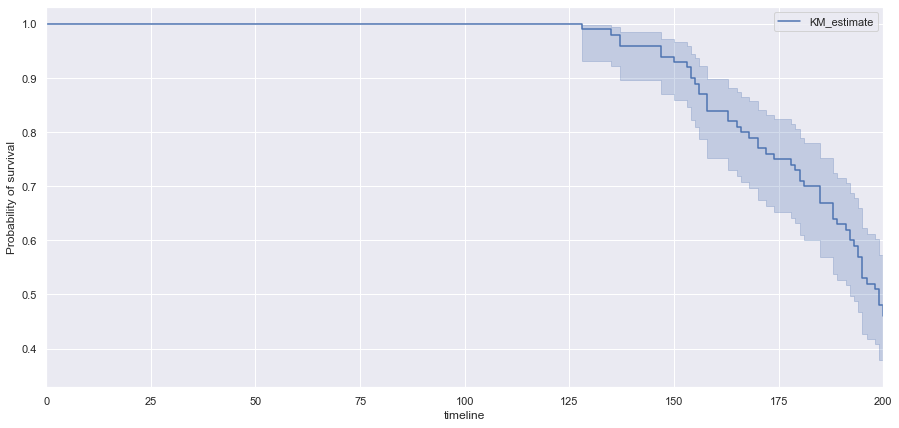

In [10]:
# create kaplan meier curve
data = train_censored[index_names+['breakdown']].groupby('unit_nr').last()

plt.figure(figsize=(15,7))
survival = KaplanMeierFitter()
survival.fit(data['time_cycles'], data['breakdown'])
survival.plot()
plt.ylabel("Probability of survival")
plt.show()
plt.close()

The KaplanMeier curve provides us with some initial information of survival probabilities. For example, engines have a 100% probability of surviving the first 128 time_cycles. After that point the first engines start to break down, but there is still a 46% probability of the engine surviving past 200 time_cycles.

# CoxTimeVaryingFitter
I have tried several variations with the regular CoxPHFitter, but it did not yield good results for this particular case. The reason I wanted to use the regular CoxPHFitter is because it comes with a predict_expectation right out of the box, providing time till event (or in our case RUL) predictions.  

Finally, I've setteled on the CoxTimeVaryingFitter. Which can leverage the timeseries nature of the data, as it is able to take multiple observations for each engine into account. The downside to this model is, its results are less intuitive to interpret. In general, higher partial hazards indicate a higher risk of failure, but this is no direct indication of time till event. For a more detailed explanation you can refer to the blog post.

In [11]:
train_cols = index_names + remaining_sensors + ['start', 'breakdown']
predict_cols = ['time_cycles'] + remaining_sensors + ['start', 'breakdown']  # breakdown value will be 0

In [12]:
ctv = CoxTimeVaryingFitter()
ctv.fit(train_censored[train_cols], id_col="unit_nr", event_col='breakdown', 
        start_col='start', stop_col='time_cycles', show_progress=True, step_size=1)

Iteration 8: norm_delta = 0.00000, step_size = 1.00000, ll = -63.86010, newton_decrement = 0.00000, seconds_since_start = 0.1Convergence completed after 8 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 18627 periods, 100 subjects, 54 events>

<lifelines.CoxTimeVaryingFitter: fitted with 18627 periods, 100 subjects, 54 events>
         event col = 'breakdown'
number of subjects = 100
 number of periods = 18627
  number of events = 54
    log-likelihood = -63.86
  time fit was run = 2020-09-02 15:26:11 UTC

---
       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
s_2    2.05       7.75       0.72             0.64             3.45                 1.90                31.64
s_3    0.07       1.07       0.04            -0.01             0.15                 0.99                 1.16
s_4    0.16       1.18       0.05             0.07             0.26                 1.07                 1.29
s_7   -1.09       0.34       0.50            -2.07            -0.11                 0.13                 0.90
s_8   -5.03       0.01       4.84           -14.51             4.45                 0.00                85.79
s_9   -0.02       0.98       0.04            -0.10             0.05 

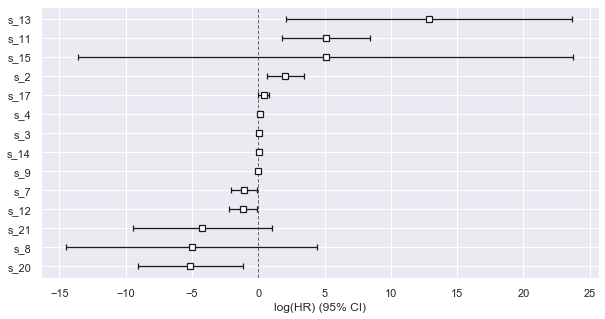

In [13]:
ctv.print_summary()

plt.figure(figsize=(10,5))
ctv.plot()
plt.show()
plt.close()

In [14]:
display(ctv.summary)

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
s_2,2.047076,7.745221,0.718074,0.639677,3.454475,1.895868e+00,3.164168e+01,2.850787,0.004361,7.841085
s_3,0.070081,1.072595,0.040596,-0.009485,0.149647,9.905601e-01,1.161425e+00,1.726324,0.084289,3.568509
s_4,0.164506,1.178811,0.047103,0.072187,0.256825,1.074856e+00,1.292819e+00,3.492512,0.000478,11.029195
s_7,-1.086248,0.337480,0.500341,-2.066899,-0.105597,1.265777e-01,8.997872e-01,-2.171014,0.029930,5.062258
s_8,-5.030594,0.006535,4.838076,-14.513049,4.451861,4.978091e-07,8.578647e+01,-1.039792,0.298436,1.744504
s_9,-0.022045,0.978196,0.038271,-0.097054,0.052964,9.075067e-01,1.054392e+00,-0.576025,0.564598,0.824703
s_11,5.120580,167.432485,1.703049,1.782666,8.458494,5.945688e+00,4.714953e+03,3.006714,0.002641,8.564765
s_12,-1.136686,0.320881,0.528755,-2.173028,-0.100345,1.138325e-01,9.045256e-01,-2.149739,0.031576,4.985035
s_13,12.897450,399292.512067,5.513919,2.090367,23.704532,8.087885e+00,1.971276e+10,2.339071,0.019332,5.692885
s_14,0.040657,1.041495,0.042873,-0.043373,0.124687,9.575541e-01,1.132794e+00,0.948305,0.342974,1.543827


The log-likelihood is an indication of goodness of fit, values closer to zero indicate a better fit.  
Looking at the p-values of the coefficients, sensors 9 and 15 have p-values > 0.50. However, removing the sensors returned a log-likelihood of -64.20, indicating the model becomes worse when removing these sensors.
Last but not least the exp(coef) show the scaling hazard risk. E.g. an increment of 1 unit for the sensor values of sensor 11 increases the risk of breakdown by 167.43 [1-3]

# predict and evaluate

In [15]:
df = train_censored.groupby("unit_nr").last()
df = df[df['breakdown'] == 0]  # get engines from dataset which are still functioning so we can predict their RUL
df_to_predict = df[df['breakdown'] == 0].copy()

In [16]:
predictions = ctv.predict_log_partial_hazard(df_to_predict[predict_cols])
predictions.rename(columns={0: "predictions"}, inplace=True)

df_last = train.groupby('unit_nr').last()
predictions['RUL'] = df_to_predict['RUL']
predictions.head(10)

,predictions,RUL
2,-1.128757,87
5,-1.607369,69
7,3.073379,59
9,21.145492,1
10,11.751951,22
11,4.391817,40
15,14.439742,7
16,20.540832,9
17,-3.512471,76
20,10.624723,34


When comparing the log_partial_hazard with computed RUL you can see it generally informs quite well about imminence of breakdown. Higher log_partial_hazards are returned for engines more at risk of breaking down most of the time.

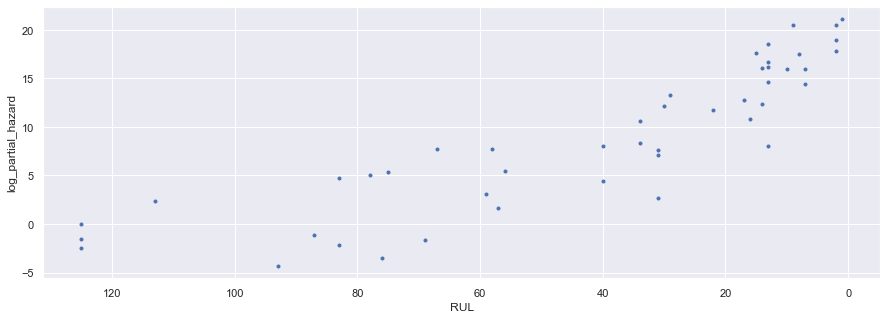

In [16]:
plt.figure(figsize=(15,5))
plt.plot(predictions['RUL'], predictions['predictions'], '.b')
xlim = plt.gca().get_xlim()
plt.xlim(xlim[1], xlim[0])
plt.xlabel('RUL')
plt.ylabel('log_partial_hazard')

plt.show()

Graph reconfirms higher log_partial_hazard generally informs on the imminence of breakdown.  
Let's see how the hazard of the engines behave over time

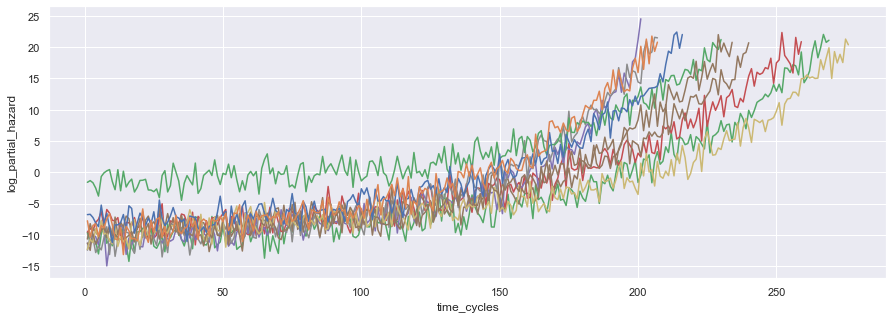

In [17]:
# now lets look at some hazard trajectories
X = train.loc[train['unit_nr'].isin(df_to_predict.index)]
X_unique = len(X['unit_nr'].unique())

plt.figure(figsize=(15,5))

for i in range(1, X_unique, 2):
    X_sub = X.loc[X['unit_nr'] == i]
    predictions = ctv.predict_partial_hazard(X_sub)[0].values
    plt.plot(X_sub['time_cycles'].values, np.log(predictions))

plt.xlabel('time_cycles')
plt.ylabel('log_partial_hazard')
plt.show()

### Note: The practical thing to do here would be to set a threshold after which maintenance should be performed.  
However that doesn't really inform you of the remaining useful life.  
You could in theory build another model to predict when this threshold is reached to get more of an indication of time till event.  
I'm going to try and relate the hazard values directly to computed RUL

## Regressing the log_partial_hazard to RUL
First predict the hazard for all engines in the set and check their relation to RUL

In [18]:
df_hazard = train_censored.copy()
df_hazard['hazard'] = ctv.predict_log_partial_hazard(df_hazard)
df_hazard.head()

,unit_nr,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,RUL,breakdown,start,hazard
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,125,0,0,-6.856341
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,125,0,1,-4.700971
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,125,0,2,-7.370774
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,125,0,3,-8.140738
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,125,0,4,-5.260691


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


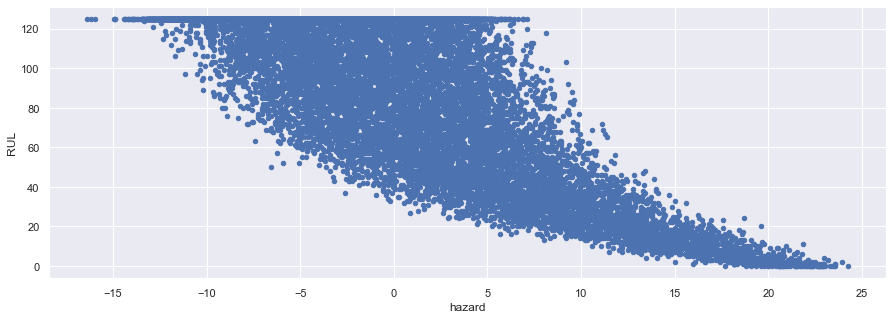

In [19]:
df_hazard.plot('hazard', 'RUL', 'scatter', figsize=(15,5))
plt.xlabel('hazard')
plt.ylabel('RUL')
plt.show()

Note: The relationship is non-linear and there is quite a lot of spread, making it difficult to pinpoint RUL based on the log_partial_hazard.  
We can try fitting an exponential model.

In [20]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [21]:
# https://stackoverflow.com/questions/52930401/how-to-get-a-robust-nonlinear-regression-fit-using-scipy-optimize-least-squares
from scipy.optimize import curve_fit

def exponential_model(z, a, b):
    return a * np.exp(-b * z)

### Idea of fit
Note: Below graph is to showcase the idea. The line that was actually fitted is less accurate as it takes data points of all engines into account.

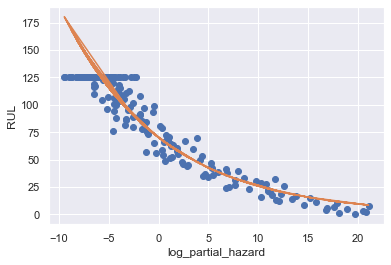

In [22]:
# check specific unit_nr
y_hat = exponential_model(df_hazard.loc[df_hazard['unit_nr']==1, 'hazard'], 70, 0.1)

plt.plot(df_hazard.loc[df_hazard['unit_nr']==1, 'hazard'], df_hazard.loc[df_hazard['unit_nr']==1, 'RUL'], 'o',
        df_hazard.loc[df_hazard['unit_nr']==1, 'hazard'], y_hat)
plt.xlabel("log_partial_hazard")
plt.ylabel("RUL")
plt.show()
plt.close()

In [23]:
popt, pcov = curve_fit(exponential_model, df_hazard['hazard'], df_hazard['RUL'])
popt  # the coefficients

array([8.85954699e+01, 4.35302167e-02])

In [25]:
# prep test set
test = X_test.drop(labels=drop_labels, axis=1)
test['breakdown'] = 0
test['start'] = test['time_cycles'] - 1

In [26]:
# predict and evaluate
y_hat = exponential_model(df_hazard['hazard'], *popt)
evaluate(df_hazard['RUL'], y_hat, 'train')

y_pred = ctv.predict_log_partial_hazard(test.groupby('unit_nr').last())
y_hat = exponential_model(y_pred, *popt)
evaluate(y_test, y_hat)

train set RMSE:26.302858422243872, R2:0.5487597218187095
test set RMSE:27.135244169256758, R2:0.5736091039386049


# repeat but train on complete dataset

In [27]:
ctv2 = CoxTimeVaryingFitter()
ctv2.fit(train[train_cols], id_col="unit_nr", event_col='breakdown', 
        start_col='start', stop_col='time_cycles', show_progress=True)

Iteration 8: norm_delta = 0.00000, step_size = 1.00000, ll = -114.77106, newton_decrement = 0.00000, seconds_since_start = 0.2Convergence completed after 8 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 20631 periods, 100 subjects, 100 events>

In [28]:
train['hazard'] = ctv2.predict_log_partial_hazard(train)
popt2, pcov2 = curve_fit(exponential_model, train['hazard'], train['RUL'])

y_hat = exponential_model(train['hazard'], *popt2)
evaluate(train['RUL'], y_hat, 'train')

y_pred = ctv2.predict_log_partial_hazard(test.groupby('unit_nr').last())
y_hat = exponential_model(y_pred, *popt2)
evaluate(y_test, y_hat)

train set RMSE:26.226364780597272, R2:0.6039289060308352
test set RMSE:26.580988808221285, R2:0.5908498441209542


Although it doesn't come as close to the SVR or time-series analysis solutions, part of the innaccuracy can be explained by fitting another model ontop of the predicted log_partial_hazard, which results in errors ontop of errors (as no model is perfect). I believe when you step away from the RUL paradigm we've been using and set a threshold for the log_partial_hazard this method could be very appropriate to define when maintenance is required.

I would like to give a special thanks to lifelines author Cameron Davidson-Pilon for taking the time to provide me with some pointers on how to best utilize the lifelines package for the dataset at hand!

## references and reading materials

In [29]:
# references
# [1] https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqhow-are-the-likelihood-ratio-wald-and-lagrange-multiplier-score-tests-different-andor-similar/
# [2] https://www.reddit.com/r/statistics/comments/23sk6h/what_does_a_loglikelihood_value_indicate_and_how/
# [3] https://medium.com/@zachary.james.angell/applying-survival-analysis-to-customer-churn-40b5a809b05a


# reading materials
# Kaplan Meier Curve
# https://lifelines.readthedocs.io/en/latest/Survival%20analysis%20with%20lifelines.html
# https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator

# model interpretation & loglikelihood
# https://medium.com/@zachary.james.angell/applying-survival-analysis-to-customer-churn-40b5a809b05a
# https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqhow-are-the-likelihood-ratio-wald-and-lagrange-multiplier-score-tests-different-andor-similar/
# https://www.reddit.com/r/statistics/comments/23sk6h/what_does_a_loglikelihood_value_indicate_and_how/


# Generic stuff
# https://towardsdatascience.com/churn-prediction-and-prevention-in-python-2d454e5fd9a5
# https://github.com/CamDavidsonPilon/lifelines/issues/619  # use CPH model with continuous variables
# https://towardsdatascience.com/survival-analysis-part-a-70213df21c2e
# https://en.wikipedia.org/wiki/Survival_analysis


# https://datascience.stackexchange.com/questions/14252/how-to-use-survival-analysis-for-predictive-maintenance-for-time-series-data
# https://square.github.io/pysurvival/tutorials/maintenance.html
# https://stats.stackexchange.com/questions/177175/survival-analysis-account-for-repeated-measures?noredirect=1&lq=1
# https://stats.stackexchange.com/questions/199744/using-survival-analysis-with-multiple-events

# belowlink did not work out the way I imagined, hence I switched to the timevaryingfitter
# https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html#clusters-correlations  
# https://lifelines.readthedocs.io/en/latest/Examples.html#correlations-between-subjects-in-a-cox-model